In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
import os
import numpy as np
from astropy.table import Table, hstack
from scipy.spatial import cKDTree as KDTree

In [35]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
    parentfile = '/Users/mtownsend/anaconda/Data/lrg-survey-dr8-try5.fits'
    isedfile = '/Users/mtownsend/anaconda/Data/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits'
    kcorrfile = '/Users/mtownsend/anaconda/Data/lrgs_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits'

    print('Reading {}'.format(parentfile))
    parent = Table.read(parentfile)
    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
    print('Reading {}'.format(kcorrfile))
    kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 photometric bands.'.format(
        len(keep), chi2min, snrmin))
    
    cat = dict()
#     cat['weight'] = len(keep) * parent['COUNT'][keep].data / np.sum(parent['COUNT'][keep].data)
#     cat['redshift'] = kcorr['Z'][keep].data
#     cat['Mstar'] = ised['MSTAR_50'][keep].data
#     cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
#     cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
#     cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
#     cat['gr'] = cat['Mg'] - cat['Mr']
#     cat['rz'] = cat['Mr'] - cat['Mz']

#     with np.errstate(invalid='ignore'):
#         cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
#         cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
#         cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
    kcorr.remove_columns(['Z', 'ISEDFIT_ID', 'MAGGIES', 'IVARMAGGIES'])
    out = hstack([ised[keep]])
    
    return out

In [36]:
ised = read_isedfit()
ngal = len(ised)

Reading /Users/mtownsend/anaconda/Data/lrg-survey-dr8-try5.fits
Reading /Users/mtownsend/anaconda/Data/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits
Reading /Users/mtownsend/anaconda/Data/lrgs_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits
Read 740800 galaxies with chi2 < 10 and S/N > 3.0 in all 5 photometric bands.


In [38]:
print(ngal)
ised[:5]

740800


ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,37.92862397555869,-1.161706870298361,0.67909867,8.758764e-10 .. 3.521448e-08,1.8400667e+20 .. 4.1029328e+17,8.5453766e-10 .. 4.068169e-08,0,646,1,1,3.3725965,856121740000.0,5625974000.0,11.716446,6.9197736,6.7283525,0.09570866,0.013521288,0.406731,0.2539062,-1.0,52.25331,-3.0674648,-3.0674648,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.714107,6.852187,6.7283525,0.100916214,0.013521288,0.406731,0.27063605,-1.0,-3.0698042,-3.0698042,-15.0,-15.0,-1.0,-1.0,-1.0,11.685022,6.5373616,6.217908,0.15982851,0.013938655,0.36642438,0.32161894,-1.0,-2.883374,-2.9752085,-12.988878,-12.746897,-1.0,-1.0,-1.0,0.0473063,0.691841,0.7367016,0.15706308,0.0016931291,0.15224552,0.10111185,0.0,0.7654195,0.52829623,2.9617014,3.047122,0.0,0.0,0.0
1,37.36433263365962,-0.5526036281833835,0.58823,1.0108094e-09 .. 3.5016896e-08,1.756022e+20 .. 4.1662062e+17,1.1007772e-09 .. 3.577936e-08,0,2340,1,1,0.5872936,655970600000.0,3975141000.0,11.598271,7.552701,7.351299,0.100700654,0.010581199,0.92989254,0.3127259,-1.0,52.18259,-3.183116,-3.183116,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.525414,6.852187,6.0498047,0.24326818,0.016210476,0.27576527,0.3127259,-1.0,-3.229599,-3.2332754,-11.289713,-10.224919,-1.0,-1.0,-1.0,11.510478,6.576889,6.035269,0.27105987,0.015960611,0.39563385,0.34368062,-1.0,-2.5882602,-2.916991,-10.46587,-10.0402775,-1.0,-1.0,-1.0,0.06223297,0.8511988,0.9279564,0.185541,0.0040946673,0.30413774,0.11226401,0.0,0.78411436,0.5529258,2.993179,3.1165295,0.0,0.0,0.0
2,36.14626661726619,-1.0471812065670618,0.57408994,2.2709878e-09 .. 4.1128153e-08,2.2029595e+20 .. 4.574978e+17,2.4056281e-09 .. 4.5368484e-08,0,96,1,1,4.3237314,375537800000.0,2160053200.0,11.354112,4.4932547,2.601672,1.1316091,0.025259817,1.2715038,0.7490966,-1.0,54.403122,1.4036493,0.82411575,-1.0979775,-0.91137516,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.45475,7.364327,3.860954,1.6016691,0.025259817,1.2715038,0.714047,-1.0,1.403903,0.82436943,-1.0979775,-0.91137516,-1.0,-1.0,-1.0,11.420673,6.332656,3.5401685,1.8138689,0.024062939,1.4035059,0.6906544,-1.0,1.3938854,0.8449945,-1.0315427,-0.8950097,-1.0,-1.0,-1.0,0.04415536,1.062475,0.64251024,0.6130794,0.0038481816,0.21829808,0.0847875,0.0,0.13588428,0.20799923,0.21570073,0.17660852,0.0,0.0,0.0
3,37.83887909073174,0.8529345319035284,0.77483577,1.1353731e-09 .. 5.8114253e-08,1.6420305e+20 .. 4.273587e+17,1.0276312e-09 .. 6.434959e-08,0,4135,1,1,5.2646275,1035910300000.0,4798534000.0,11.81159,3.9778688,3.6049159,0.18647714,0.009885669,0.9766792,0.29984018,-1.0,52.134842,-2.9846783,-2.9846783,-7.8135657,-6.3376775,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.811732,4.3878155,3.6049159,0.2689638,0.012683684,0.6880155,0.29984018,-1.0,-0.92848

In [39]:
print(type(ised))

mstar = np.array(ised['MSTAR'])
print(type(mstar))

ra_MOUS = np.array(ised['RA'])
dec_MOUS = np.array(ised['DEC'])
mstar_err = np.array(ised['MSTAR_ERR'])
print(len(ra_MOUS))

<class 'astropy.table.table.Table'>
<class 'numpy.ndarray'>
740800


11.367039


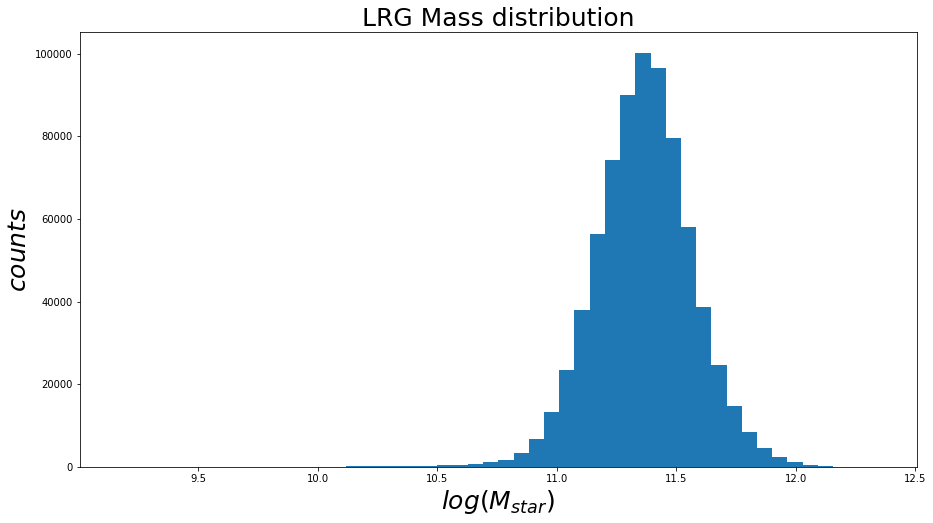

In [40]:
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend

print(np.median(mstar))

plt.rcParams["figure.figsize"] = [15, 8]
plt.title("LRG Mass distribution", fontsize=25)
plt.hist(mstar, bins=50)
# plt.axvline(linewidth=1, color='r')
plt.xlabel(r'$log(M_{star})$', fontsize=25)
plt.ylabel(r'$counts$', fontsize=25)
plt.show()

In [7]:
# Reads in data files for use in readData.py

hdu_north = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-north-specObj-dr14.fits') # this matches SDSS LRGs to MzLS/BASS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_south = fits.open('//Users/mtownsend/anaconda/Data/survey-dr8-south-specObj-dr14.fits')# this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_sdss = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr8.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p010-250p015-dr8.fits') # this is one sweep file of the DECaLS data

SpecObj_data_north = hdu_north[1].data
SpecObj_data_south = hdu_south[1].data
SDSS_data = hdu_sdss[1].data
DECaLS_data1 = hdu_sweep1[1].data
DECaLS_data2 = hdu_sweep2[1].data

id_LRG1, specobjid_LRG1, ra_LRG1, dec_LRG1, ra_BKG1, dec_BKG1, z_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_BKG1, rflux_BKG1, zflux_BKG1, w1flux_BKG1, w2flux_BKG1, w3flux_BKG1, w4flux_BKG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1flux_ivar_LRG1, w2flux_ivar_LRG1, w3flux_ivar_LRG1, w4flux_ivar_LRG1, gflux_ivar_BKG1, rflux_ivar_BKG1, zflux_ivar_BKG1, w1flux_ivar_BKG1, w2flux_ivar_BKG1, w3flux_ivar_BKG1, w4flux_ivar_BKG1, mw_transmission_g_LRG1, mw_transmission_r_LRG1, mw_transmission_z_LRG1, mw_transmission_g_BKG1, mw_transmission_r_BKG1, mw_transmission_z_BKG1, mw_transmission_w1_LRG1, mw_transmission_w2_LRG1, mw_transmission_w3_LRG1, mw_transmission_w4_LRG1, mw_transmission_w1_BKG1, mw_transmission_w2_BKG1, mw_transmission_w3_BKG1, mw_transmission_w4_BKG1 = readData(SpecObj_data_south, SDSS_data, DECaLS_data1)
id_LRG2, specobjid_LRG2, ra_LRG2, dec_LRG2, ra_BKG2, dec_BKG2, z_LRG2, gflux_LRG2, rflux_LRG2, zflux_LRG2, w1flux_LRG2, w2flux_LRG2, w3flux_LRG2, w4flux_LRG2, gflux_BKG2, rflux_BKG2, zflux_BKG2, w1flux_BKG2, w2flux_BKG2, w3flux_BKG2, w4flux_BKG2, gflux_ivar_LRG2, rflux_ivar_LRG2, zflux_ivar_LRG2, w1flux_ivar_LRG2, w2flux_ivar_LRG2, w3flux_ivar_LRG2, w4flux_ivar_LRG2, gflux_ivar_BKG2, rflux_ivar_BKG2, zflux_ivar_BKG2, w1flux_ivar_BKG2, w2flux_ivar_BKG2, w3flux_ivar_BKG2, w4flux_ivar_BKG2, mw_transmission_g_LRG2, mw_transmission_r_LRG2, mw_transmission_z_LRG2, mw_transmission_g_BKG2, mw_transmission_r_BKG2, mw_transmission_z_BKG2, mw_transmission_w1_LRG2, mw_transmission_w2_LRG2, mw_transmission_w3_LRG2, mw_transmission_w4_LRG2, mw_transmission_w1_BKG2, mw_transmission_w2_BKG2, mw_transmission_w3_BKG2, mw_transmission_w4_BKG2 = readData(SpecObj_data_south, SDSS_data, DECaLS_data2)


print("end readdata")

done reading in SDSS
['0' '0' '0' ... '0' '0' '0']
done finding LRG flags
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4488579
done creating unique IDs for brick file
done identifying LRGs in survey brick
643560
done making survey cuts
done reading in SDSS
['0' '0' '0' ... '0' '0' '0']
done finding LRG flags
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4076998
done creating unique IDs for brick file
done identifying LRGs in survey brick
253596
done making survey cuts
end readdata


In [8]:
# calculate LRG magnitudes

gmag_LRG_nocuts = 22.5 - 2.5 * np.log10(gflux_LRG1)
rmag_LRG_nocuts = 22.5 - 2.5 * np.log10(rflux_LRG1)
zmag_LRG_nocuts = 22.5 - 2.5 * np.log10(zflux_LRG1)
    
# calculate BKG magnitudes

gmag_BKG1 = 22.5 - 2.5 * np.log10(gflux_BKG1)
gmag_BKG2 = 22.5 - 2.5 * np.log10(gflux_BKG2)
rmag_BKG1 = 22.5 - 2.5 * np.log10(rflux_BKG1)
rmag_BKG2 = 22.5 - 2.5 * np.log10(rflux_BKG2)
zmag_BKG1 = 22.5 - 2.5 * np.log10(zflux_BKG1)
zmag_BKG2 = 22.5 - 2.5 * np.log10(zflux_BKG2)

gmag_BKG = np.concatenate([gmag_BKG1, gmag_BKG2])
rmag_BKG = np.concatenate([rmag_BKG1, rmag_BKG2])
zmag_BKG = np.concatenate([zmag_BKG1, zmag_BKG2])
  
    
zmag_cut_test = np.concatenate([zmag_LRG_nocuts, zmag_BKG])
    
# calculate LRG (g-r) and (r-z) colors
    
grcolor_LRG_nocuts = gmag_LRG_nocuts - rmag_LRG_nocuts
rzcolor_LRG_nocuts = rmag_LRG_nocuts - zmag_LRG_nocuts
    
# calculate BKG (g-r) and (r-z) colors
    
grcolor_BKG = gmag_BKG - rmag_BKG
rzcolor_BKG = rmag_BKG - zmag_BKG

# create full list of LRG attributes

ra_LRG_nocuts = ra_LRG1
# print(len(ra_LRG_nocuts))
ra_BKG_nocuts = np.concatenate([ra_BKG1, ra_BKG2])
dec_LRG_nocuts = dec_LRG1
dec_BKG_nocuts = np.concatenate([dec_BKG1, dec_BKG2])
z_LRG_nocuts = z_LRG1
id_LRG_nocuts = id_LRG1

ra_nocuts = np.concatenate([ra_LRG_nocuts, ra_BKG_nocuts])
dec_nocuts = np.concatenate([dec_LRG_nocuts, dec_BKG_nocuts])

# cut for zmag brighter than 22.75

ra_LRG = ra_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
dec_LRG = dec_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
id_LRG = id_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

ra_BKG = ra_BKG_nocuts
dec_BKG = dec_BKG_nocuts

z_LRG = z_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.75))]

gmag_LRG = gmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rmag_LRG = rmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
zmag_LRG = zmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
grcolor_LRG = grcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rzcolor_LRG = rzcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

# combine LRG and BKG lists

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])

grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 


In [46]:
from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

mous_cat = SkyCoord(ra=ra_MOUS*u.degree, dec=dec_MOUS*u.degree)                          

my_cat = SkyCoord(ra=ra_LRG*u.degree, dec=dec_LRG*u.degree)                                

idx, sep2d, dist3d = match_coordinates_sky(my_cat, mous_cat, nthneighbor=1)
# idx, sep2d, dist3d = my_cat.match_to_catalog_sky(mous_cat)

print(ra_LRG[0])
print(ra_MOUS[0])

mass_LRG = mstar[idx]
print(len(mass_LRG))

ra_cut = ra_MOUS[np.where((ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
dec_cut = dec_MOUS[np.where((ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
print(len(ra_cut))
print(len(ra_MOUS))

241.07328804964362
37.92862397555869
1875
1226
740800


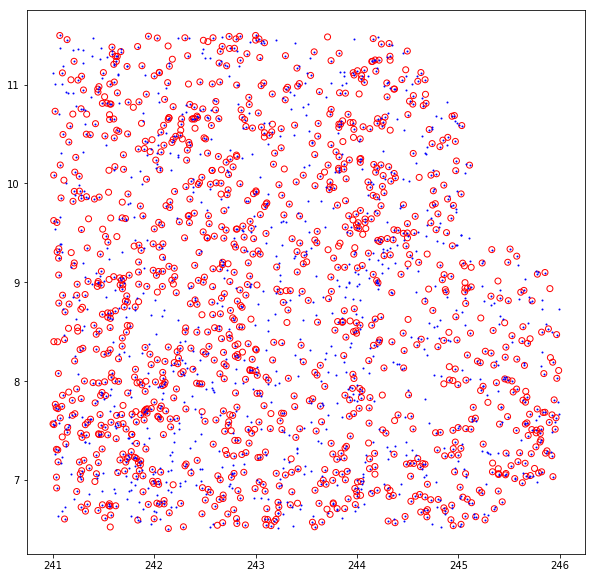

In [48]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(ra_cut, dec_cut, facecolors='none', edgecolors='r')
plt.scatter(ra_LRG, dec_LRG, c="blue", s=1)
# plt.scatter(ra_LRG, dec_LRG, c='blue')
plt.show()